# 2.03d Analysing Glycaemic Variability
This notebook looks at blood glucose in terms of glycaemic variability.

Glycaemic control has traditionally been the measured using HbA1c, a term used for glycated haemoglobin, which is made when the glucose sticks to red blood cells. As blood sugar can't be used properly, more of it binds to blood cells and increases the volume in haemoglobin. Readings are taken quarterly as red blood cells are active for 2-3 months. Thus, a high HbA1c result indicates high blood sugar levels, and with it the various risks and complications that a patient faces. HbA1c will not give an idea of fluctuations in blood sugar levels whereas CGM monitors offer the ability to monitor BG at a much greater resolution. Glycaemic variability can measured more with a range of metrics, including but not limited to:
- Time in range (TIR)
- Coefficient of Variation (CV)
- Standard Deviation (SD)
- Mean Amplitude of Glycaemic Excursions (MAGE)
- Continuous overall net glycaemic action (CONGA)
- High/Low Blood Glucose Index (H/LBGI)

This analysis will focus on the SD, CV and MAGE. SD is measured by:

$SD = \sqrt{\frac{\sum{(x-\bar{x})^2}}{n-1}}$

where $\bar{x}$ is the mean of the glucose data.

CV is also a statistical metric which focuses on the diversity of glucose data, and is one of the most used metrics for glycaemic variation \cite{Rodard2018} <NEEDS REFERENCE AS OFFLINE>. CV is calculated as:
$CV = \frac{SD}{\bar{x}}$

CV is a unitless measure, and is often expressed as a percentage.

MAGE is a measure of the amplitude of glycaemic excursions originally proposed by Service et al \cite{Service1970}, and is calculated as the mean of the absolute differences between consecutive peaks and troughs in glucose data. It is a measure of the magnitude of fluctuations in glucose levels, and is often used to assess glycaemic variability in patients with diabetes. MAGE is an algorithm that Surabhi et al \cite{Surabhi2013} formalise as:
$MAGE = \sum{\frac{\lambda}{n}}$ if $\lambda > v$

where:
- $\lambda = $ each blood glucose increase or decrease (nadir-peak or peak-nadir).
- $n$ is the number of glucose measurements.
- $v$ is one standarard deviation from the mean of the glucose data for the period.

The features extracted at each interval for the night are qualifying excursion amplitudes based on an implementation of MAGE provided in the `cgmquantify` package \cite{Bent2021), rather than using an overall mean for the night, which can help as a feature for variability over time and when implementing any model for prediction or output of an objective function.



In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
from datetime import time

from src.sample_filter import SampleFilter
from src.configurations import ThirtyMinute
from src.features import FeatureSet
from src.config import PROCESSED_DATA_DIR

2025-07-12 22:25:19.027 | INFO     | src.config:<module>:11 - PROJ_ROOT path is: C:\Users\ross\OneDrive\Documents\Masters\Project\masters_project


In [2]:

night_start = time(17, 0)
morning_end = time(11, 0)
sampling = ThirtyMinute()
# min_nights = 30
# missed_intervals = 1
# max_break_run = 1
# cob_nan_min = 0.2
# iob_nan_min = 0.05
# bg_nan_min = 0.2
# sample_long = SampleFilter(
#     night_start=night_start,
#     morning_end=morning_end,
#     sampling=sampling,
#     missed_intervals=missed_intervals,
#     max_break_run= max_break_run,
#     min_nights=min_nights,
#     cob_nan_min=cob_nan_min,
#     iob_nan_min=iob_nan_min,
#     bg_nan_min=bg_nan_min
# )
# df = sample_long.get_consolidated_df()

df = pd.read_parquet(PROCESSED_DATA_DIR / 'night_clusters.parquet')
df['time'] = df.index.get_level_values('datetime').time


In [3]:
df.head()

night_start_date  bg mean  bg min  bg max  \
id       datetime                                                        
15558575 2018-04-17 17:00:00       2018-04-17    145.5   127.0   159.0   
         2018-04-17 17:30:00       2018-04-17     97.5    93.0   102.0   
         2018-04-17 18:00:00       2018-04-17     71.5    66.0    77.0   
         2018-04-17 18:30:00       2018-04-17     76.0    76.0    76.0   
         2018-04-17 19:00:00       2018-04-17    110.0   110.0   110.0   

                              iob mean  iob max  cob mean  cob max  cluster  \
id       datetime                                                             
15558575 2018-04-17 17:00:00     2.609    7.776     16.25     65.0        2   
         2018-04-17 17:30:00     6.045    6.425     58.50     59.0        2   
         2018-04-17 18:00:00     4.101    4.825     49.00     52.0        2   
         2018-04-17 18:30:00     1.623    1.623     51.00     51.0        2   
         2018-04-17 19:00:00     1.869    1.869     37.00     37.0        2   

                                  time  
id       datetime                       
15558575 2018-04-17 17:00:00  17:00:00  
         2018-04-17 17:30:00  17:30:00  
         2018-04-17 18:00:00  18:00:00  
         2018-04-17 18:30:00  18:30:00  
         2018-04-17 19:00:00  19:00:00

In [13]:
features = FeatureSet(df, sample_rate=sampling.minutes)
features.scale_features()
df_with_AGE = features.add_AGE_features(mode='excursion_amplitude_filled')

Scaling ['iob mean', 'cob mean', 'bg mean', 'bg min', 'iob max', 'cob max', 'bg max'] columns


In [12]:
df_with_AGE.head()

night_start_date   bg mean    bg min    bg max  \
id       datetime                                                             
15558575 2018-04-17 17:00:00       2018-04-17  0.294199  0.243094  0.331492   
         2018-04-17 17:30:00       2018-04-17  0.161602  0.149171  0.174033   
         2018-04-17 18:00:00       2018-04-17  0.089779  0.074586  0.104972   
         2018-04-17 18:30:00       2018-04-17  0.102210  0.102210  0.102210   
         2018-04-17 19:00:00       2018-04-17  0.196133  0.196133  0.196133   

                              iob mean   iob max  cob mean  cob max  cluster  \
id       datetime                                                              
15558575 2018-04-17 17:00:00  0.237328  0.323632  0.101562  0.40625        2   
         2018-04-17 17:30:00  0.319366  0.293640  0.365625  0.36875        2   
         2018-04-17 18:00:00  0.272951  0.258120  0.306250  0.32500        2   
         2018-04-17 18:30:00  0.213786  0.187035  0.318750  0.31875        2   
         2018-04-17 19:00:00  0.219660  0.192496  0.231250  0.23125        2   

                                  time  excursion_amplitude  
id       datetime                                            
15558575 2018-04-17 17:00:00  17:00:00             0.204420  
         2018-04-17 17:30:00  17:30:00             0.204420  
         2018-04-17 18:00:00  18:00:00             0.457182  
         2018-04-17 18:30:00  18:30:00             0.457182  
         2018-04-17 19:00:00  19:00:00             0.457182

['iob mean', 'cob mean', 'bg mean', 'excursion_amplitude']


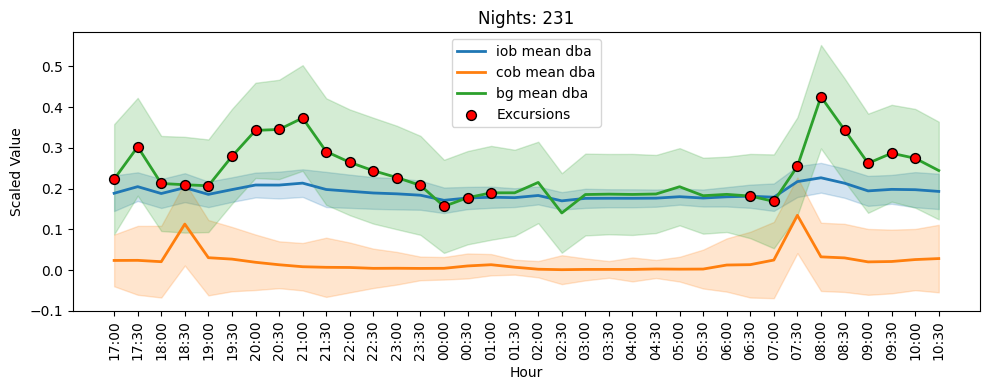

In [16]:
from src.time_series_analysis import plot_night_time_series
cluster_df = df_with_AGE[df_with_AGE['cluster'] == 3]
plot_night_time_series(cluster_df, night_start=night_start.hour, morning_end=morning_end.hour, method='dba', include_excursions=True, excursion_plot_type='markers')

In [39]:
221+247+218+181


867